# Fitting impedance spectra

## 1. Import and initialize equivalent circuit(s)

To begin we will import the Randles' circuit and a custom circuit from the impedance package. A full list of currently available circuits are available in the [documentation](https://impedancepy.readthedocs.io/en/latest/circuits.html).

In [1]:
import sys
sys.path.append('../../../')

from impedance.circuits import Randles, CustomCircuit

The classes we just imported represent different equivalent circuit models. To actually use them we want to initialize a specific instance and provide an initial guess for the parameters and any other options.

*E.g. for the randles circuit, one of the options is for a constant phase element (CPE) instead of an ideal capacitor.*

In [2]:
randles = Randles(initial_guess=[.01, .005, .1, .001, 200])
randlesCPE = Randles(initial_guess=[.01, .005, .1, .9, .001, 200], CPE=True)

Defining the custom circuit works a little differently. Here we pass a string comprised of the circuit elements grouped either in series (separated with a `-`) or in parallel (using the form `p(X,Y)`). Elements with multiple parameters are given in the form `X/Y`

In [3]:
customCircuit = CustomCircuit(initial_guess=[.01, .005, .1, .005, .1, .001, 200],
                              circuit='R0-p(R1,C1)-p(R2,C2)-W1')

As of version 0.4, you can now specify values you want to hold constant. For example,

In [4]:
customConstantCircuit = CustomCircuit(initial_guess=[None, .005, .1, .005, .1, .001, None], constants={'R0': 0.02, 'W1_1': 200},
                              circuit='R0-p(R1,C1)-p(R2,C2)-W1')

Each of the circuit objects we create can be printed in order to see the properties that have been defined for that circuit.

In [5]:
print(customConstantCircuit)


Circuit string: R0-p(R1,C1)-p(R2,C2)-W1
Fit: False

Constants:
     R0 = 2.00e-02 [Ohm]
   W1_1 = 2.00e+02 [sec]

Initial guesses:
     R1 = 5.00e-03 [Ohm]
     C1 = 1.00e-01 [F]
     R2 = 5.00e-03 [Ohm]
     C2 = 1.00e-01 [F]
   W1_0 = 1.00e-03 [Ohm]



## 2. Formulate data

Several convenience functions for importing data exist in the impedance.preprocessing module; however, here we will simply read in a `.csv` file containing frequencies as well as real and imaginary impedances using the numpy package.

In [6]:
import numpy as np

data = np.genfromtxt('../../../data/exampleData.csv', delimiter=',')

frequencies = data[:,0]
Z = data[:,1] + 1j*data[:,2]

# keep only the impedance data in the first quandrant
frequencies = frequencies[np.imag(Z) < 0]
Z = Z[np.imag(Z) < 0]

## 3. Fit the equivalent circuits to a spectrum

Each of the circuit classes has a `.fit()` method which finds the best fitting parameters.

After fitting a circuit, the fit parameters rather that the inital guesses are shown when printing.

In [7]:
randles.fit(frequencies, Z)
randlesCPE.fit(frequencies, Z)
customCircuit.fit(frequencies, Z)
customConstantCircuit.fit(frequencies, Z)

print(customConstantCircuit)


Circuit string: R0-p(R1,C1)-p(R2,C2)-W1
Fit: True

Constants:
     R0 = 2.00e-02 [Ohm]
   W1_1 = 2.00e+02 [sec]

Initial guesses:
     R1 = 5.00e-03 [Ohm]
     C1 = 1.00e-01 [F]
     R2 = 5.00e-03 [Ohm]
     C2 = 1.00e-01 [F]
   W1_0 = 1.00e-03 [Ohm]

Fit parameters:
     R1 = 6.79e-03  (+/- 1.08e-03) [Ohm]
     C1 = 5.62e+00  (+/- 1.96e+00) [F]
     R2 = 3.91e-03  (+/- 1.09e-03) [Ohm]
     C2 = 1.36e+00  (+/- 2.61e-01) [F]
   W1_0 = 5.88e-02  (+/- 1.25e-03) [Ohm]



## 4a. Predict circuit model and visualize with matplotlib

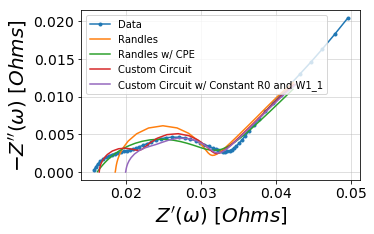

In [8]:
import matplotlib.pyplot as plt
from impedance.plotting import plot_nyquist

f_pred = np.logspace(5,-2)

randles_fit = randles.predict(f_pred)
randlesCPE_fit = randlesCPE.predict(f_pred)
customCircuit_fit = customCircuit.predict(f_pred)
customConstantCircuit_fit = customConstantCircuit.predict(f_pred)

fig, ax = plt.subplots(figsize=(5,5))

plot_nyquist(ax, Z)
plot_nyquist(ax, randles_fit, fmt='-')
plot_nyquist(ax, randlesCPE_fit, fmt='-')
plot_nyquist(ax, customCircuit_fit, fmt='-')
plot_nyquist(ax, customConstantCircuit_fit, fmt='-')

ax.legend(['Data', 'Randles', 'Randles w/ CPE', 'Custom Circuit', 'Custom Circuit w/ Constant R0 and W1_1'])
plt.show()

## 4b. Or use the convenient plotting method included in the package

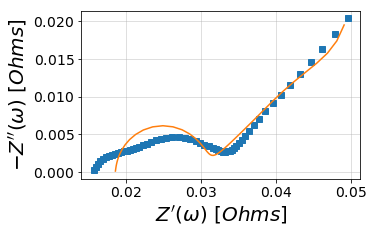

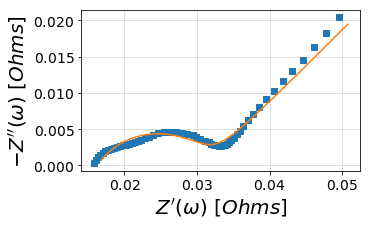

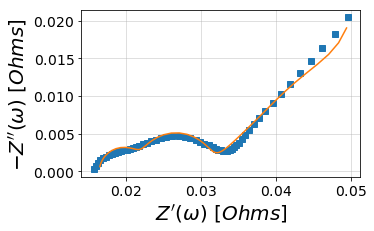

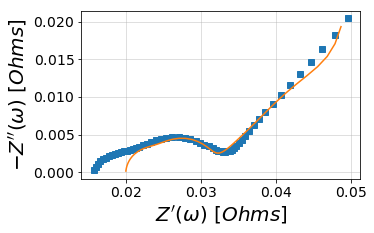

In [9]:
randles.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
randlesCPE.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
customConstantCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')

plt.show()